<a href="https://colab.research.google.com/github/Pedro-Boechat/trainee/blob/main/Periodo6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TF-IDF is a method which gives us a numerical weightage of words which reflects how important the particular word is to a document in a corpus

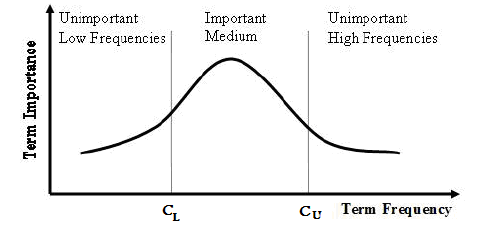


A frequência de termos quando utilizada pode ser eficaz, porém alguns termos que não são eliminados podem atrapalhar a análise. Existem algumas palavras que são muito comuns e se repetem por todos os documentos de texto. Elas possuem significado e não podem ser eliminadas no pré-processamento. 

Para realizar uma análise mais precisa do corpus utilizamos não mais apenas a frequência simples e sim a frequência multiplicada pelo inverso da frequência considerando o conjunto completo de documentos. Por exemplo: imagine um conjunto de 150 documentos no qual a palavra “claro”: aparece em 149 documentos, “médico”: em 98 , “plantas”: em 89.

A técnica do TF-IDF desconsidera as palavras com maior frequência entre documentos e dá maior importância para as palavras que tem maior frequência e não estão presentes em muitos documentos.

tf-idf = term_frequency * inverse_document_frequency

term_frequency = number of times a given term appears in document

inverse_document_frequency = log(total number of documents / number of documents with term) + 1*****

Quanto maior o valor, mais relevante é a palavra

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import time
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [96]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

dataset_path = '/content/gdrive/MyDrive/Musical_instruments_reviews.csv'

Mounted at /content/gdrive


In [206]:
df = pd.read_csv(dataset_path)

In [ ]:
df.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5.0,Five Stars,1405814400,"07 20, 2014"
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014"
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4.0,Good for coated.,1405987200,"07 22, 2014"
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,1404172800,"07 1, 2014"
10260,A2WA8TDCTGUADI,B00JBIVXGC,TheTerrorBeyond,"[0, 0]","These strings are really quite good, but I wou...",4.0,"These strings are really quite good, but I wou...",1405468800,"07 16, 2014"


In [98]:
for col in df.columns:
    print(col, df[col].isnull().sum())

reviewerID 0
asin 0
reviewerName 27
helpful 0
reviewText 7
overall 0
summary 0
unixReviewTime 0
reviewTime 0


Como há poucos valores NA, decidi dropar todos

In [207]:
df = df.dropna()

In [100]:
df['overall'].value_counts()

5.0    6912
4.0    2079
3.0     771
2.0     249
1.0     216
Name: overall, dtype: int64

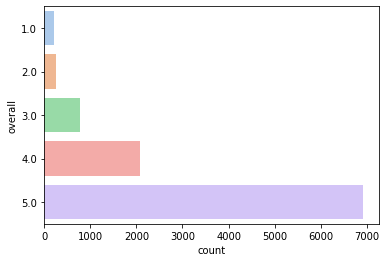

In [101]:
sns.countplot(y='overall', data=df, palette='pastel')

Nota-se desbalanceamento dos dados

In [102]:
from sklearn.utils import resample
# Separar a maioria e minoria
df_5 = df[df['overall']==5.0]
df_4 = df[df['overall']==4.0]
df_3 = df[df['overall']==3.0]
df_2 = df[df['overall']==2.0]
df_1 = df[df['overall']==1.0]

# Downsample
df_5 = resample(df_5,
                                 replace=False,    
                                 n_samples=249)
df_4 = resample(df_4,
                                 replace=False,    
                                 n_samples=249)
df_3 = resample(df_3, 
                                 replace=False,    
                                 n_samples=249)


# Combinar a maioria downsampled com a minoria
df = pd.concat([df_5,df_4, df_3, df_2, df_1])

In [103]:
df['overall'].value_counts()

5.0    249
4.0    249
3.0    249
2.0    249
1.0    216
Name: overall, dtype: int64

Criando uma coluna para a classificação binária. Valores acima de 3 serão 1; e o restante será 0. Essa classificação indicará se a avaliação do usuário foi positiva ou negativa.

In [208]:
df.loc[((df['overall'] <= 3) 
       ), 'total'] = 0

df['total'] = df['total'].fillna(1)

In [ ]:
df['total'].value_counts()

In [107]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,total
10022,A3R8TPM1N7HFS4,B00B1N06PO,"Amazon Customer ""kateTaylor""","[7, 7]",Tascam is an industry leader in pro audio and ...,5.0,Absolutely THE best under $100.00 headphones y...,1362182400,"03 2, 2013",1.0
8870,A1TLMSOE1VRDZI,B004XNK7AI,Igneous,"[2, 2]",- This tuner is affordable and it works well....,5.0,"Easy to stay in tune. Small, handy & time saving",1343347200,"07 27, 2012",1.0
9324,A1ZGNCN1VRUO1H,B005MR6IHK,JC,"[0, 0]",I have owned two Snark headstock tuners (the b...,5.0,Great alternative to a Snark,1378166400,"09 3, 2013",1.0
7741,A2B58VXLLOFQKR,B003AYC1SM,James Moulton,"[0, 1]",After trying about every comp out there for ye...,5.0,"Great Compressor, like a Script Logo",1308182400,"06 16, 2011",1.0
3963,ATSVUBE2115N1,B0009EU01G,Aaron Madden,"[0, 0]",Great cord for the money. Works well with the ...,5.0,Cool cord,1357603200,"01 8, 2013",1.0


In [210]:
rws = df.loc[:, ['reviewText', 'overall', 'total']]

# Pré processamento

## Passo a passo

In [109]:
rws['reviewText'] = rws['reviewText'].apply(word_tokenize)
rws.head()
# Tokenizando

,reviewText,overall,total
10022,"[Tascam, is, an, industry, leader, in, pro, au...",5.0,1.0
8870,"[-, This, tuner, is, affordable, and, it, work...",5.0,1.0
9324,"[I, have, owned, two, Snark, headstock, tuners...",5.0,1.0
7741,"[After, trying, about, every, comp, out, there...",5.0,1.0
3963,"[Great, cord, for, the, money, ., Works, well,...",5.0,1.0


In [ ]:
rws['reviewText'] = rws['reviewText'].apply(lambda x: [word.lower() for word in x])
rws.head()

# Lowercase

,reviewText,overall,summary
0,"[not, much, to, write, about, here, ,, but, it...",5.0,good
1,"[the, product, does, exactly, as, it, should, ...",5.0,Jake
2,"[the, primary, job, of, this, device, is, to, ...",5.0,It Does The Job Well
3,"[nice, windscreen, protects, my, mxl, mic, and...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[this, pop, filter, is, great, ., it, looks, a...",5.0,No more pops when I record my vocals.


In [ ]:
punc = string.punctuation
rws['reviewText'] = rws['reviewText'].apply(lambda x: [word for word in x if word not in punc])
rws.head()
#Removendo pontuação

,reviewText,overall,summary
0,"[not, much, to, write, about, here, but, it, d...",5.0,good
1,"[the, product, does, exactly, as, it, should, ...",5.0,Jake
2,"[the, primary, job, of, this, device, is, to, ...",5.0,It Does The Job Well
3,"[nice, windscreen, protects, my, mxl, mic, and...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[this, pop, filter, is, great, it, looks, and,...",5.0,No more pops when I record my vocals.


In [ ]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
rws['reviewText'] = rws['reviewText'].apply(lambda x: [word for word in x if word not in stop_words])
rws.head()

# Tirando stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,reviewText,overall,summary
0,"[much, write, exactly, 's, supposed, filters, ...",5.0,good
1,"[product, exactly, quite, affordable.i, realiz...",5.0,Jake
2,"[primary, job, device, block, breath, would, o...",5.0,It Does The Job Well
3,"[nice, windscreen, protects, mxl, mic, prevent...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[pop, filter, great, looks, performs, like, st...",5.0,No more pops when I record my vocals.


In [ ]:
nltk.download('averaged_perceptron_tagger')

rws['reviewText'] = rws['reviewText'].apply(nltk.tag.pos_tag)
rws.head()

# Para fazer o lemmatization, é necessário classificar as palavras de acordo com sua classe gramatical

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,reviewText,overall,summary
0,"[(much, JJ), (write, WP), (exactly, RB), ('s, ...",5.0,good
1,"[(product, NN), (exactly, RB), (quite, RB), (a...",5.0,Jake
2,"[(primary, JJ), (job, NN), (device, NN), (bloc...",5.0,It Does The Job Well
3,"[(nice, JJ), (windscreen, JJ), (protects, NNS)...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[(pop, NN), (filter, NN), (great, JJ), (looks,...",5.0,No more pops when I record my vocals.


In [ ]:
nltk.download('wordnet')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
rws['reviewText'] = rws['reviewText'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
rws.head()

# Este trecho torna legível ao algoritmo a classificação das palavras feita na etapa anterior

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,reviewText,overall,summary
0,"[(much, a), (write, n), (exactly, r), ('s, n),...",5.0,good
1,"[(product, n), (exactly, r), (quite, r), (affo...",5.0,Jake
2,"[(primary, a), (job, n), (device, n), (block, ...",5.0,It Does The Job Well
3,"[(nice, a), (windscreen, a), (protects, n), (m...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[(pop, n), (filter, n), (great, a), (looks, v)...",5.0,No more pops when I record my vocals.


In [ ]:
wnl = WordNetLemmatizer()
rws['reviewText'] = rws['reviewText'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
rws.head()

# Lemmatization

,reviewText,overall,summary
0,"[much, write, exactly, 's, suppose, filter, po...",5.0,good
1,"[product, exactly, quite, affordable.i, realiz...",5.0,Jake
2,"[primary, job, device, block, breath, would, o...",5.0,It Does The Job Well
3,"[nice, windscreen, protects, mxl, mic, prevent...",5.0,GOOD WINDSCREEN FOR THE MONEY
4,"[pop, filter, great, look, performs, like, stu...",5.0,No more pops when I record my vocals.


## A função

Juntando todos os passos acima numa função, obtemos:

In [211]:
nltk.download('wordnet')
nltk.download('punkt')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def preprocessnltk(rws):
  rws['reviewText'] = rws['reviewText'].apply(word_tokenize)

  rws['reviewText'] = rws['reviewText'].apply(lambda x: [word.lower() for word in x])
 
  punc = string.punctuation
  rws['reviewText'] = rws['reviewText'].apply(lambda x: [word for word in x if word not in punc])

  nltk.download('stopwords')
  stop_words = set(stopwords.words('english'))
  rws['reviewText'] = rws['reviewText'].apply(lambda x: [word for word in x if word not in stop_words])

  nltk.download('averaged_perceptron_tagger')
  rws['reviewText'] = rws['reviewText'].apply(nltk.tag.pos_tag)

  rws['reviewText'] = rws['reviewText'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

  wnl = WordNetLemmatizer()
  rws['reviewText'] = rws['reviewText'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

  return rws

rws = preprocessnltk(rws)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [212]:
rws['reviewText'] = [' '.join(map(str,l)) for l in rws['reviewText']]
rws.head()

# Os textos da função são retornados dentro de uma lista. Isto é um problema para o algoritmo
# Sendo assim, esta etapa elimina a lista

,reviewText,overall,total
0,much write exactly 's suppose filter pop sound...,5.0,1.0
1,product exactly quite affordable.i realize dou...,5.0,1.0
2,primary job device block breath would otherwis...,5.0,1.0
3,nice windscreen protects mxl mic prevents pops...,5.0,1.0
4,pop filter great look performs like studio fil...,5.0,1.0


# Bag of words

In [114]:
vect = CountVectorizer()
vect.fit(rws['reviewText'])

CountVectorizer()

In [115]:
print("Tamanho: {}".format(len(vect.vocabulary_)))
print("Conteúdo: {}".format(vect.vocabulary_))

Tamanho: 6675
Conteúdo: {'tascam': 5797, 'industry': 3030, 'leader': 3334, 'pro': 4531, 'audio': 623, 'many': 3558, 'year': 6633, 'quality': 4638, 'unmatched': 6226, 'dollar': 1826, 'exception': 2129, 'excellent': 2127, 'sound': 5409, 'premium': 4491, 'fit': 2320, 'comfort': 1268, 'wear': 6460, 'day': 1568, 'station': 5541, 'ca': 1014, 'go': 2603, 'wrong': 6608, 're': 4692, 'order': 4111, 'pair': 4210, 'tuner': 6112, 'affordable': 367, 'work': 6573, 'well': 6478, 'purchase': 4608, 'six': 5274, 'far': 2223, 'sturdy': 5652, 'come': 1267, 'battery': 728, 'box': 897, 'install': 3065, 'yourself': 6658, 'actually': 311, 'sit': 5267, 'one': 4072, 'thought': 5919, 'break': 913, 'turn': 6121, 'main': 3526, 'head': 2770, 'pop': 4430, 'right': 4912, 'back': 671, 'goose': 2616, 'neck': 3899, 'lead': 3333, 'bright': 923, 'low': 3481, 'light': 3387, 'display': 1778, 'daylight': 1569, 'start': 5531, 'dim': 1719, 'dark': 1552, 'need': 3902, 'new': 3925, 'fairly': 2210, 'large': 3305, 'disk': 1770, 'st

In [116]:
bagofwords = vect.transform(rws['reviewText'])

In [121]:
print(bagofwords)

  (0, 623)	1
  (0, 1014)	1
  (0, 1268)	1
  (0, 1568)	1
  (0, 1826)	2
  (0, 2127)	1
  (0, 2129)	1
  (0, 2320)	1
  (0, 2603)	1
  (0, 3030)	1
  (0, 3334)	1
  (0, 3558)	1
  (0, 4111)	1
  (0, 4210)	1
  (0, 4491)	1
  (0, 4531)	1
  (0, 4638)	2
  (0, 4692)	1
  (0, 5409)	1
  (0, 5541)	1
  (0, 5797)	1
  (0, 6226)	1
  (0, 6460)	1
  (0, 6608)	1
  (0, 6633)	1
  :	:
  (1211, 2603)	1
  (1211, 2792)	1
  (1211, 2853)	1
  (1211, 3387)	1
  (1211, 3393)	1
  (1211, 3410)	1
  (1211, 3600)	1
  (1211, 3649)	1
  (1211, 3721)	1
  (1211, 3783)	1
  (1211, 3924)	1
  (1211, 3925)	1
  (1211, 4650)	1
  (1211, 4692)	1
  (1211, 4709)	1
  (1211, 5020)	1
  (1211, 5084)	1
  (1211, 5347)	2
  (1211, 5566)	1
  (1211, 5583)	1
  (1211, 5934)	1
  (1211, 6287)	1
  (1211, 6420)	1
  (1211, 6521)	1
  (1211, 6647)	1


In [122]:
print(bagofwords.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [123]:
vect.get_feature_names_out()

array(['00', '000', '004', ..., 'zipper', 'zone', 'zoom'], dtype=object)

# TFIDF

In [ ]:
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
data = pd.DataFrame(denselist, columns=feature_names)

# Tentativa de fazer um dataframe com tfidf. nao sei se é um bom caminho

In [ ]:
dense = 0
denselist = 0
vectors = 0
feature_names = 0

### Isso aqui é pq pelo método que eu to fazendo, a ram fica destruída por essas variaveis, ja que sao listas imensas. entao eu deixo elas pequenas pra abrir espaço dps que ja usei

In [215]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(rws['reviewText'])


In [214]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

Onde o valor é 0, não há ocorrencia da palvra na frase em questão. Para melhor visualizar, pegarei algumas palavras mais frequentes e relevantes, para que vejamos os valores de TFIDF delas em cada frase

In [ ]:
data['much']

0        0.241310
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
10222    0.000000
10223    0.023573
10224    0.077838
10225    0.000000
10226    0.000000
Name: much, Length: 10227, dtype: float64

In [ ]:
data['great']

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.099925
           ...   
10222    0.297066
10223    0.018061
10224    0.000000
10225    0.025161
10226    0.000000
Name: great, Length: 10227, dtype: float64

# Tentando treinar

In [126]:
pip install sklearn2pmml

     |████████████████████████████████| 6.0 MB 4.6 MB/s 
  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.78.0-py3-none-any.whl size=5996535 sha256=79aff0633f83bc823531f972f6858723a48e5d37d8d5ba0eb5ad711fe3068186
  Stored in directory: /root/.cache/pip/wheels/99/46/0c/118f1c1ad8a84cb536b5adb8838257b2cfb3c3b193ee7aed8d
Successfully built sklearn2pmml


In [127]:
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn.pipeline import Pipeline 
from sklearn.svm import SVC


## Binário

In [158]:
X = vectors
Y = rws['total']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

In [129]:
from sklearn import preprocessing, svm

In [159]:
clf = svm.SVC()
clf.fit(X_train,y_train)

SVC()

In [160]:
print(f'A acurácia do algoritmo de Support Vector Machine binário foi de {round(clf.score(X_test,y_test)*100,2)}%')

A acurácia do algoritmo de Support Vector Machine binário foi de 70.78%


In [161]:
y_pred = clf.predict(X_test)

In [162]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[133,   9],
       [ 62,  39]])

Há muitos erros por parte do código ao identificar avaliações positivas

## Categorico

In [153]:
X = vectors
Y = rws['overall']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

In [ ]:
Y

In [154]:
clf = svm.SVC()
clf.fit(X_train,y_train)

SVC()

In [155]:
print(f'A acurácia do algoritmo de Support Vector Machine foi de {round(clf.score(X_test,y_test)*100,2)}%')

A acurácia do algoritmo de Support Vector Machine foi de 34.98%


In [156]:
y_pred = clf.predict(X_test)

In [157]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[11, 23,  3,  2,  3],
       [ 6, 20,  3,  9,  6],
       [ 0, 19, 18, 10,  8],
       [ 1, 15, 11, 14, 11],
       [ 2, 14,  1, 11, 22]])

O código tem dificuldade em diferenciar avaliações com nota 2 das outras

## Binário sem resample

In [216]:
X = vectors
Y = rws['total']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

In [217]:
clf = svm.SVC()
clf.fit(X_train,y_train)

SVC()

In [218]:
print(f'A acurácia do algoritmo de Support Vector Machine binário sem resample foi de {round(clf.score(X_test,y_test)*100,2)}%')

A acurácia do algoritmo de Support Vector Machine binário sem resample foi de 89.78%


In [219]:
y_pred = clf.predict(X_test)

In [220]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[   4,  209],
       [   0, 1833]])

Imenso desbalanceamento levou a um algoritmo de péssimos resultados, mesmo que com alta acurácia. Neste caso, ele indicou todas as samples como positivas.

## Categórico sem resample

In [221]:
X = vectors
Y = rws['overall']
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

In [222]:
clf = svm.SVC()
clf.fit(X_train,y_train)

SVC()

In [223]:
print(f'A acurácia do algoritmo de Support Vector Machine foi de {round(clf.score(X_test,y_test)*100,2)}%')

A acurácia do algoritmo de Support Vector Machine foi de 67.45%


In [224]:
y_pred = clf.predict(X_test)

In [225]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[   0,    0,    0,    0,   35],
       [   0,    0,    0,    1,   58],
       [   0,    0,    0,    9,  149],
       [   0,    0,    0,    8,  411],
       [   0,    0,    0,    3, 1372]])

Assim como no modelo anterior, o imenso balanceamento fez com que o algoritmo taxasse todas as samples como overall 5.0

# Tokenizando com tensorflow

In [226]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer

In [227]:
vect = CountVectorizer()
vect.fit(rws['reviewText'])

CountVectorizer()

In [165]:
vocabulary_size = len(vect.vocabulary_)
tokenizer = Tokenizer(num_words= vocabulary_size, filters='')
tokenizer.fit_on_texts(rws['reviewText'])

In [ ]:
len(tokenizer.word_counts)

27764

In [228]:
sequencia = tokenizer.texts_to_sequences(rws['reviewText'])

In [229]:
from keras.preprocessing.sequence import pad_sequences

sequencia_padded = pad_sequences(
    sequencia, maxlen=40, padding='post', truncating='post'
)

In [183]:
sequencia_padded[0]

array([ 458, 1719, 3439,  421,  459,  114,   62,   36, 3440,  519,  519,
       2520,  338,    7,   36, 2521,   78, 1489,  339,  151, 1124,  102,
          1,   20,  192,   58,  148,  539,  631,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

## Categórico

In [169]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(rws[['overall']]).toarray())

## One hot encoding


In [170]:
encoder_df

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
1207,1.0,0.0,0.0,0.0,0.0
1208,1.0,0.0,0.0,0.0,0.0
1209,1.0,0.0,0.0,0.0,0.0
1210,1.0,0.0,0.0,0.0,0.0


In [189]:
Y = np.array(encoder_df)
X_train, X_test, y_train, y_test = train_test_split(sequencia_padded,Y, test_size=0.2)

In [173]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.initializers import Constant

In [190]:
model = Sequential()
model.add(Embedding(27764, 128, input_length=40))
model.add(LSTM(64))
model.add(Dense(64, activation='tanh'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [191]:
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
31/31 [==============================] - 7s 102ms/step - loss: 1.6116 - accuracy: 0.1930 - val_loss: 1.6052 - val_accuracy: 0.1934
Epoch 2/20
31/31 [==============================] - 2s 77ms/step - loss: 1.5908 - accuracy: 0.3179 - val_loss: 1.6040 - val_accuracy: 0.2263
Epoch 3/20
31/31 [==============================] - 2s 76ms/step - loss: 1.4305 - accuracy: 0.4654 - val_loss: 1.6103 - val_accuracy: 0.2881
Epoch 4/20
31/31 [==============================] - 2s 76ms/step - loss: 0.9274 - accuracy: 0.6481 - val_loss: 1.6200 - val_accuracy: 0.3292
Epoch 5/20
31/31 [==============================] - 2s 76ms/step - loss: 0.5157 - accuracy: 0.8266 - val_loss: 1.9495 - val_accuracy: 0.3128
Epoch 6/20
31/31 [==============================] - 3s 82ms/step - loss: 0.3100 - accuracy: 0.9040 - val_loss: 2.1837 - val_accuracy: 0.3416
Epoch 7/20
31/31 [==============================] - 2s 76ms/step - loss: 0.1451 - accuracy: 0.9567 - val_loss: 2.9227 - val_accuracy: 0.2963
Epoch 8/20
3

In [193]:
model = Sequential()
model.add(Embedding(27764, 128, input_length=40))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [194]:
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
31/31 [==============================] - 8s 136ms/step - loss: 1.6103 - accuracy: 0.2105 - val_loss: 1.6008 - val_accuracy: 0.2099
Epoch 2/20
31/31 [==============================] - 3s 101ms/step - loss: 1.4934 - accuracy: 0.4675 - val_loss: 1.5007 - val_accuracy: 0.2963
Epoch 3/20
31/31 [==============================] - 3s 101ms/step - loss: 0.9806 - accuracy: 0.6491 - val_loss: 1.5816 - val_accuracy: 0.3539
Epoch 4/20
31/31 [==============================] - 3s 101ms/step - loss: 0.4532 - accuracy: 0.8473 - val_loss: 1.8441 - val_accuracy: 0.3580
Epoch 5/20
31/31 [==============================] - 3s 101ms/step - loss: 0.1920 - accuracy: 0.9515 - val_loss: 2.2598 - val_accuracy: 0.3498
Epoch 6/20
31/31 [==============================] - 3s 101ms/step - loss: 0.0877 - accuracy: 0.9804 - val_loss: 2.5464 - val_accuracy: 0.3374
Epoch 7/20
31/31 [==============================] - 3s 103ms/step - loss: 0.0375 - accuracy: 0.9959 - val_loss: 3.0208 - val_accuracy: 0.3210


## Binário

In [196]:
Y = np.array(rws['total'])
X_train, X_test, y_train, y_test = train_test_split(sequencia_padded,Y, test_size=0.2)

In [199]:
model = Sequential()
model.add(Embedding(27764, 128, input_length=40))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [200]:
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
31/31 [==============================] - 12s 212ms/step - loss: 0.6857 - accuracy: 0.5697 - val_loss: 0.6599 - val_accuracy: 0.6379
Epoch 2/20
31/31 [==============================] - 3s 94ms/step - loss: 0.6578 - accuracy: 0.5614 - val_loss: 0.6371 - val_accuracy: 0.6379
Epoch 3/20
31/31 [==============================] - 3s 81ms/step - loss: 0.4520 - accuracy: 0.7833 - val_loss: 0.6171 - val_accuracy: 0.6996
Epoch 4/20
31/31 [==============================] - 2s 80ms/step - loss: 0.1558 - accuracy: 0.9432 - val_loss: 0.7842 - val_accuracy: 0.6584
Epoch 5/20
31/31 [==============================] - 3s 81ms/step - loss: 0.0873 - accuracy: 0.9742 - val_loss: 0.9724 - val_accuracy: 0.6749
Epoch 6/20
31/31 [==============================] - 3s 83ms/step - loss: 0.0263 - accuracy: 0.9886 - val_loss: 1.2010 - val_accuracy: 0.6626


In [204]:
model = Sequential()
model.add(Embedding(27764, 128, input_length=40))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [205]:
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
31/31 [==============================] - 9s 138ms/step - loss: 0.6852 - accuracy: 0.5759 - val_loss: 0.6624 - val_accuracy: 0.6379
Epoch 2/20
31/31 [==============================] - 3s 101ms/step - loss: 0.5446 - accuracy: 0.7172 - val_loss: 0.6269 - val_accuracy: 0.6914
Epoch 3/20
31/31 [==============================] - 3s 100ms/step - loss: 0.2266 - accuracy: 0.9257 - val_loss: 0.7042 - val_accuracy: 0.6955
Epoch 4/20
31/31 [==============================] - 3s 101ms/step - loss: 0.0654 - accuracy: 0.9825 - val_loss: 0.9764 - val_accuracy: 0.7325
Epoch 5/20
31/31 [==============================] - 3s 102ms/step - loss: 0.0142 - accuracy: 0.9969 - val_loss: 1.1480 - val_accuracy: 0.6955
Epoch 6/20
31/31 [==============================] - 3s 102ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 1.3750 - val_accuracy: 0.7078
Epoch 7/20
31/31 [==============================] - 3s 103ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.5331 - val_accuracy: 0.7119


## Categórico sem resample

In [230]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(rws[['overall']]).toarray())

## One hot encoding


In [231]:
Y = np.array(encoder_df)
X_train, X_test, y_train, y_test = train_test_split(sequencia_padded,Y, test_size=0.2)

In [232]:
model = Sequential()
model.add(Embedding(27764, 128, input_length=40))
model.add(LSTM(64))
model.add(Dense(64, activation='tanh'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [233]:
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
256/256 [==============================] - 26s 84ms/step - loss: 0.9784 - accuracy: 0.6751 - val_loss: 0.9349 - val_accuracy: 0.6774
Epoch 2/20
256/256 [==============================] - 20s 79ms/step - loss: 0.8373 - accuracy: 0.6868 - val_loss: 0.9044 - val_accuracy: 0.6725
Epoch 3/20
256/256 [==============================] - 20s 79ms/step - loss: 0.7223 - accuracy: 0.7299 - val_loss: 0.9433 - val_accuracy: 0.6500
Epoch 4/20
256/256 [==============================] - 20s 79ms/step - loss: 0.6073 - accuracy: 0.7759 - val_loss: 1.0469 - val_accuracy: 0.6373


Resultados muito similares aos apresentados no modelo SVM acima no relatório. O desbalanceamento leva a um grande problema

In [234]:
model = Sequential()
model.add(Embedding(27764, 128, input_length=40))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [235]:
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
256/256 [==============================] - 39s 130ms/step - loss: 0.9359 - accuracy: 0.6734 - val_loss: 0.8707 - val_accuracy: 0.6755
Epoch 2/20
256/256 [==============================] - 27s 106ms/step - loss: 0.7596 - accuracy: 0.7049 - val_loss: 0.8961 - val_accuracy: 0.6716
Epoch 3/20
256/256 [==============================] - 31s 120ms/step - loss: 0.6118 - accuracy: 0.7631 - val_loss: 0.9407 - val_accuracy: 0.6720
Epoch 4/20
256/256 [==============================] - 27s 105ms/step - loss: 0.4491 - accuracy: 0.8302 - val_loss: 1.0898 - val_accuracy: 0.6413


## Binário sem resample

In [236]:
Y = np.array(rws['total'])
X_train, X_test, y_train, y_test = train_test_split(sequencia_padded,Y, test_size=0.2)

In [237]:
model = Sequential()
model.add(Embedding(27764, 128, input_length=40))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [238]:
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
256/256 [==============================] - 24s 83ms/step - loss: 0.3679 - accuracy: 0.8818 - val_loss: 0.3666 - val_accuracy: 0.8680
Epoch 2/20
256/256 [==============================] - 22s 84ms/step - loss: 0.2819 - accuracy: 0.8994 - val_loss: 0.3784 - val_accuracy: 0.8680
Epoch 3/20
256/256 [==============================] - 21s 81ms/step - loss: 0.2008 - accuracy: 0.9259 - val_loss: 0.3952 - val_accuracy: 0.8715
Epoch 4/20
256/256 [==============================] - 21s 81ms/step - loss: 0.1463 - accuracy: 0.9499 - val_loss: 0.4309 - val_accuracy: 0.8348
Epoch 5/20
256/256 [==============================] - 20s 78ms/step - loss: 0.1055 - accuracy: 0.9687 - val_loss: 0.4876 - val_accuracy: 0.8548
Epoch 6/20
256/256 [==============================] - 20s 77ms/step - loss: 0.0804 - accuracy: 0.9756 - val_loss: 0.5847 - val_accuracy: 0.8436


In [239]:
model = Sequential()
model.add(Embedding(27764, 128, input_length=40))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [240]:
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
256/256 [==============================] - 33s 106ms/step - loss: 0.3468 - accuracy: 0.8806 - val_loss: 0.3395 - val_accuracy: 0.8700
Epoch 2/20
256/256 [==============================] - 26s 100ms/step - loss: 0.2269 - accuracy: 0.9124 - val_loss: 0.3551 - val_accuracy: 0.8602
Epoch 3/20
256/256 [==============================] - 25s 99ms/step - loss: 0.1370 - accuracy: 0.9496 - val_loss: 0.4936 - val_accuracy: 0.8583
Epoch 4/20
256/256 [==============================] - 26s 101ms/step - loss: 0.0814 - accuracy: 0.9724 - val_loss: 0.6318 - val_accuracy: 0.8436


# Fazendo testes de classificação entre 5.0 estrelas ou 4.0 estrelas

In [242]:
from sklearn.utils import resample
# Separar a maioria e minoria
df_5 = rws[rws['overall']==5.0]
df_4 = rws[rws['overall']==4.0]


# Downsample
df_5 = resample(df_5,
                                 replace=False,    
                                 n_samples=2079)
df_4 = resample(df_4,
                                 replace=False,    
                                 n_samples=2079)


# Combinar a maioria downsampled com a minoria
df = pd.concat([df_5,df_4])

In [249]:
df.loc[((df['overall'] == 4) 
       ), 'total'] = 0

df['total'] = df['total'].fillna(1)

In [254]:
df.shape

(4158, 3)

In [244]:
vect = CountVectorizer()
vect.fit(df['reviewText'])

CountVectorizer()

In [245]:
vocabulary_size = len(vect.vocabulary_)
tokenizer = Tokenizer(num_words= vocabulary_size, filters='')
tokenizer.fit_on_texts(df['reviewText'])

In [246]:
len(tokenizer.word_counts)

16219

In [247]:
sequencia = tokenizer.texts_to_sequences(df['reviewText'])

In [248]:
from keras.preprocessing.sequence import pad_sequences

sequencia_padded = pad_sequences(
    sequencia, maxlen=40, padding='post', truncating='post'
)

In [255]:
Y = np.array(df['total'])
X_train, X_test, y_train, y_test = train_test_split(sequencia_padded,Y, test_size=0.2)

In [265]:
model = Sequential()
model.add(Embedding(16219, 128, input_length=40))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [266]:
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
104/104 [==============================] - 10s 70ms/step - loss: 0.6925 - accuracy: 0.5177 - val_loss: 0.6902 - val_accuracy: 0.5216
Epoch 2/20
104/104 [==============================] - 7s 65ms/step - loss: 0.6330 - accuracy: 0.6326 - val_loss: 0.6961 - val_accuracy: 0.6058
Epoch 3/20
104/104 [==============================] - 7s 66ms/step - loss: 0.4485 - accuracy: 0.7673 - val_loss: 0.7726 - val_accuracy: 0.5938
Epoch 4/20
104/104 [==============================] - 7s 64ms/step - loss: 0.2959 - accuracy: 0.8707 - val_loss: 0.9622 - val_accuracy: 0.6166
Epoch 5/20
104/104 [==============================] - 7s 64ms/step - loss: 0.1992 - accuracy: 0.9251 - val_loss: 1.4240 - val_accuracy: 0.6070
Epoch 6/20
104/104 [==============================] - 7s 65ms/step - loss: 0.1321 - accuracy: 0.9486 - val_loss: 1.1321 - val_accuracy: 0.5925
Epoch 7/20
104/104 [==============================] - 7s 64ms/step - loss: 0.1066 - accuracy: 0.9603 - val_loss: 1.5342 - val_accuracy: 0.580

In [259]:
model = Sequential()
model.add(Embedding(16219, 128, input_length=40))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [260]:
history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
104/104 [==============================] - 15s 98ms/step - loss: 0.6807 - accuracy: 0.5508 - val_loss: 0.6596 - val_accuracy: 0.6130
Epoch 2/20
104/104 [==============================] - 9s 88ms/step - loss: 0.5158 - accuracy: 0.7514 - val_loss: 0.7075 - val_accuracy: 0.6034
Epoch 3/20
104/104 [==============================] - 9s 87ms/step - loss: 0.2615 - accuracy: 0.8915 - val_loss: 1.0619 - val_accuracy: 0.6046
Epoch 4/20
104/104 [==============================] - 11s 106ms/step - loss: 0.1124 - accuracy: 0.9561 - val_loss: 1.3873 - val_accuracy: 0.5769


# Conclusão

A partir dos resultados estudados, depreende-se que o algoritmo implementado não obtém bons resultados ao prever o overall específico de cada sample a partir do reviewText, seja por SVM, word embedding, lstm uni ou bidirecional.

Ao prever se o overall era positivo (4 ou 5) ou negativo (3,2,ou 1), o algoritmo obteve melhores resultados, alcançando por volta de 70% de acurácia. O melhor resultado obtido foi a partir do algoritmo que usava LSTM bidirecional, o qual obteve 87% de acurácia, um resultado assaz bom.

Também cabe comentar que o balanceamento dos dados é essencial para o bom resultado do algoritmo.